<a href="https://colab.research.google.com/github/virbickt/aers/blob/master/%E2%80%9E125_ipynb%E2%80%9C_kopija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 1: Data Science Fundamentals

## Sprint 2: Statistical Tests and Experiments

## Let's analyse Udacity A/B test!

<div><img style="height: 350px;" src="https://upload.wikimedia.org/wikipedia/commons/3/3b/Udacity_logo.png" /></div>

## Background

For the last day of this sprint, we are analyzing once run, online Udacity A/B test results! The dataset is part of the Udacity Google's A/B testing course, which we have watched a couple of lessons from in Subproject 2 of this sprint.

Data is available at https://docs.google.com/spreadsheets/d/1Mu5u9GrybDdska-ljPXyBjTpdZIUev_6i7t4LRDfXM8/edit#gid=0

---------

## How to start?

The data consists of two sheets, each for different group of the test. Download the sheets as CSVs and union them to form 1 dataset.

## Confidence interval for click-through rate

In order to find the confidence interval for click-through rate, we follow a four-step approach (as in [stattrek.com/estimation/difference-in-proportions](https://stattrek.com/estimation/difference-in-proportions.aspx?tutorial=AP)):


1.   Identify the sample statistic.
2.   Find the margin of error.
3.   Specify the confidence interval.

### 1. Sample statistic

We are interested in the population proportion of those who click on the link shown on the website to those who visit the website. However, as usual we have no access to the data on the proportion of the population. 

Therefore, we try to estimate the difference by choosing the difference in click-through-rates between two sample proportions, i. e. *click-through rate in control group* and *click-through rate in treatment group*, as the sample statistic.  

#### Uploading the dataset

First, we upload the datasets for control group and treatment as `control` and `treatment` respectively.

In [ ]:
import pandas as pd

control = pd.read_csv('/content/control.csv')
treatment = pd.read_csv('/content/experiment.csv')

In what follows we will be summing up the values for `Pageviews` and `Clicks`. For the purposes of readability we use the following trick: 

1.   Make a seperate column named `group` and add 'control' as values in each row.
2.   Simultaneously, group the values by this newly created column and sum up both the `Pageviews` and `Clicks` among the period of testing using `agg()` method. 

Note: although we name the column in the table that results the same way as they were named in the original, these columns store the sum total and not the values for each of the days as in the original dataset.

In [ ]:
control['group'] = 'control'

agg1 = control.groupby('group').agg(pageviews=('Pageviews', 'sum'), clicks=('Clicks', 'sum'))

In [ ]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments,group
0,"Sat, Oct 11",7723,687,134.0,70.0,control
1,"Sun, Oct 12",9102,779,147.0,70.0,control
2,"Mon, Oct 13",10511,909,167.0,95.0,control
3,"Tue, Oct 14",9871,836,156.0,105.0,control
4,"Wed, Oct 15",10014,837,163.0,64.0,control


The result looks as follows:

In [ ]:
agg1

,pageviews,clicks
group,,
control,345543,28378


Let us pull the same trick on the dataset `treatment`:

In [ ]:
treatment['group'] = 'treatment'

agg2 = treatment.groupby('group').agg(pageviews=('Pageviews', 'sum'), clicks=('Clicks', 'sum'))

agg2

,pageviews,clicks
group,,
treatment,344660,28325


We now proceed to merging the aggregated datasets.

In [ ]:
data = pd.merge(agg1, agg2, how='outer')
data

,pageviews,clicks
0,345543,28378
1,344660,28325


 For some reason, the indices get replaced by `0` and `1` for control and treatment group respectively. We therefore replace the indices by the original names of `control` and `treatment`: 

In [ ]:
index = ['control', 'treatment']

data.index = index

data

data2 = data

Now we're in a position to find the sample statistic, i. e. the difference in sample proportions in click-through-rates. Let us refer to sample proportions as *conversion rates* from now on. The conversion rate is given by:

$\hat{p} = \frac{\mathrm{clicks}}{\mathrm{pageviews}}$

We find the conversion rates for both control and treatment groups by using `.apply()`method together with `lambda` function.

In [ ]:
data['conversion_rate'] = data[['pageviews', 'clicks']].apply(
    lambda x: x[1] / x[0], axis=1
)

data

,pageviews,clicks,conversion_rate
control,345543,28378,0.082126
treatment,344660,28325,0.082182


Therefore, our conversion rates are:

$\hat{p}_{control} = \frac{\mathrm{clicks (control)}}{\mathrm{pageviews (control)}} = \frac{X_{control}}{n_{control}} = \frac{28378}{345543} = 8.212\%$

or conversion rate for control group in percent (proportion of those who clicked to those who visited the website)

$\hat{p}_{treatment} = \frac{\mathrm{clicks (treatment)}}{\mathrm{pageviews (treatment)}} = \frac{X_{treatment}}{n_{treatment}} = \frac{28325}{344660} = 8.218\%$

or conversion rate for the treatment group in percept.

We can finally proceed to find our sample statistic. Let us denote the sample statistic by $\delta$.

In [ ]:
observed_difference = data['conversion_rate'][1] - data['conversion_rate'][0]

observed_difference * 100

0.005662709158693602

Hence,

$\delta = \hat{p}_{treatment} - \hat{p}_{control} = 0.082126 - 0.082182 \approx 0.006\%$

### Margin of error

To find the margin of error, we will need to go through two extra steps:

1.   Find the standard error.
2.   Find the critical value.


Ideally, we would like to find the standard deviation. Since we do not know the population proportions, we cannot compute the standard deviation. Hence, we compute the standard error instead.

In [ ]:
import math

data['standard_error'] = data[['conversion_rate', 'pageviews']].apply(
    lambda x: ((x[0] * (1 - x[0])) / x[1]), axis=1
)

data

,pageviews,clicks,conversion_rate,standard_error
control,345543,28378,0.082126,2.181528e-07
treatment,344660,28325,0.082182,2.188490e-07


The standard error for the difference between proportions is given by:

$\mathrm{SE} = \sqrt{\frac{\hat{p}_{control}(1 - \hat{p}_{control})}{n_{control}} + \frac{\hat{p}_{treatment}(1 - \hat{p}_{treatment})}{n_{treatment}}}$

In [ ]:
standard_error_for_difference = math.sqrt(data['standard_error'][0] + data['standard_error'][1])

standard_error_for_difference

0.0006610610775037591

Hence,

$\mathrm{SE} = \sqrt{\frac{\hat{p}_{control}(1 - \hat{p}_{control})}{n_{control}} + \frac{\hat{p}_{treatment}(1 - \hat{p}_{treatment})}{n_{treatment}}} = \sqrt{\frac{0.082126  * x}{345543} + \frac{0.082182 * x}{344660}} \approx 0.000661$

Now, let us find the critical value. In order to do so, first let us compute the alpha for the confidence interval of $95\%$ which was provided:



In [ ]:
alpha = 1 - (95/100)

alpha

0.050000000000000044

Hence,

$\alpha = 1 - (95/100) = 0.05$

Since critical value is the z-score having a cumulative probability equal to critical probability, we find the critical probability by:

$p^* = 1 - \alpha /2$

In [ ]:
critical_prob = 1 - alpha / 2
critical_prob

0.975

Hence,

$p^* = 1 - \alpha/2 = 1 - 0.05/2 = 0.975$

Using Normal Distrubution Calculator, we find that our $z$-score is $1.96$. At this point we can finally compute the margin of error which is given by:

$\mathrm{ME} =$$z$-$\mathrm{score} * \mathrm{SE}$ 

In [ ]:
margin_of_error = 1.96 * standard_error_for_difference

margin_of_error

0.0012956797119073678

Hence,

$\mathrm{ME} =$$z$-$\mathrm{score} * \mathrm{SE} = 1.96 * 0.00061 \approx 0.00129$

### Confidence interval

We are finally in a position to find the confidence interval. The range of the confidence interval is defined by *sample statistic* times *margin of error*, or:

$\delta \pm \mathrm{ME}$

In [ ]:
conf_interval_upper_bound = observed_difference + margin_of_error

conf_interval_lower_bound = observed_difference - margin_of_error

conf_interval_lower_bound, conf_interval_upper_bound

(-0.0012390526203204318, 0.0013523068034943038)

In our case, the $95\%$ confidence interval is:

$0.006 + 0.00129$

Therefore, $95\%$ confidence interval is $-0.0012$ to $0.00135$. This means that we are $95\%$ confident that our that the true difference in population proportion is in the range from $-0.0012$ to $0.00135$.

Text(0.5, 0, 'Confidence interval (0.006+0.00129)')

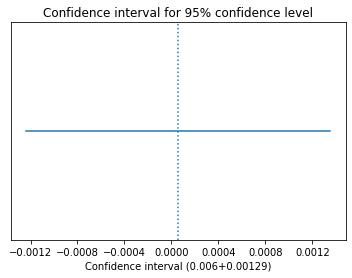

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


x = [conf_interval_lower_bound, conf_interval_upper_bound]
y = [0, 0]

fig, ax = plt.subplots()
ax.plot(x,y)
plt.axvline(observed_difference,linestyle=':')
plt.yticks([])
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.0004))
plt.title('Confidence interval for 95% confidence level')
plt.xlabel('Confidence interval (0.006+0.00129)')
#ax.fill_between(x, conf_interval_lower_bound, conf_interval_lower_bound, color='b', alpha=.1)


# Alternative approach

In [ ]:
data = pd.merge(control, treatment, how='outer', on='Date', suffixes=("_control", "_treatment")).fillna(0)

Conversion rate for treatment group (proportion of those who clicked to those who visited the website):

$\hat{p}_{treatment} = \frac{\mathrm{clicks\_treatment}}{\mathrm{pageviews\_treatment}} = \frac{X_{control}}{n_{control}}$

Observed difference:

$\delta = \hat{p}_{treatment} - \hat{p}_{control}$

Combined conversion rate (pooled probability):

$ p_{pooled} =  \frac{X_{control} + X_{treatment}}{n_{control} + n_{treatment}}$

Pooled standard error:

$\mathrm{SE} = \sqrt{p_{pooled}(1-p_{pooled})(\frac{1}{n_{control}} + \frac{1}{n_{treatment}})}$

Margin of error:

$e =$ $z$-$\mathrm{score}$ * $\mathrm{SE}$ 

Confidence interval:

$\delta \pm e$

Z-statistic:

$Z = \frac{\delta}{\mathrm{SE}} = \frac{\hat{p}_{treatment} - \hat{p}_{control}}{p_{pooled} (1 - p_{pooled}) * (\frac{1}{n_{control}} + \frac{1}{n_{treatment}})}$

P-value (for two-tailed test):

$p = 2 * (1 - \mathrm{cdf}(|Z|))$

In [ ]:
from scipy.stats import norm
import numpy as np

data['conversion_rate_control'] = data[['Pageviews_control', 'Clicks_control']].apply(
    lambda input_arr: input_arr[1] / input_arr[0], axis=1
)

data['conversion_rate_treatment'] = data[['Pageviews_treatment', 'Clicks_treatment']].apply(
    lambda input_arr: input_arr[1] / input_arr[0], axis=1
)

data['observed_difference'] = data[['conversion_rate_control', 'conversion_rate_treatment']].apply(
    lambda x: (x[1] - x[0]), axis=1
)

data['combined_conversion_rate'] = data[['Clicks_control', 'Clicks_treatment', 'Pageviews_control', 'Pageviews_treatment']].apply(
    lambda x: ((x[0] + x[1])/ (x[2] + x[3]) ), axis=1
)

data['standard_error'] = data[['combined_conversion_rate', 'Pageviews_control', 'Pageviews_treatment']].apply(
    lambda x: (np.sqrt( x[0] * (1 - x[0]) * ((1/x[1]) + (1/x[2])))), axis=1
)

data['margin_of_error_95'] = data['standard_error'].apply(
    lambda x: x * 1.96
)

data['conf_upper_bound'] = data[['observed_difference', 'margin_of_error_95']].apply(
    lambda x: (x[0] + x[1]), axis=1 
)

data['conf_lower_bound'] = data[['observed_difference', 'margin_of_error_95']].apply(
    lambda x: (x[0] - x[1]), axis=1 
)

data['z_statistic'] = data[['observed_difference', 'standard_error']].apply(
    lambda x: (x[0] / x[1]), axis=1
)

data['p_value'] = data['z_statistic'].apply(
    lambda x: 2 * (1 - norm.cdf(abs(x)))
)

data

,Date,Pageviews_control,Clicks_control,Enrollments_control,Payments_control,group_control,Pageviews_treatment,Clicks_treatment,Enrollments_treatment,Payments_treatment,group_treatment,conversion_rate_control,conversion_rate_treatment,observed_difference,combined_conversion_rate,standard_error,margin_of_error_95,conf_upper_bound,conf_lower_bound,z_statistic,p_value
0,"Sat, Oct 11",7723,687,134.0,70.0,control,7716,686,105.0,34.0,treatment,0.088955,0.088906,-0.000049,0.088931,0.004582,0.008980,0.008931,-0.009029,-0.010673,0.991484
1,"Sun, Oct 12",9102,779,147.0,70.0,control,9288,785,116.0,91.0,treatment,0.085586,0.084518,-0.001068,0.085046,0.004114,0.008064,0.006996,-0.009132,-0.259570,0.795196
2,"Mon, Oct 13",10511,909,167.0,95.0,control,10480,884,145.0,79.0,treatment,0.086481,0.084351,-0.002130,0.085418,0.003858,0.007562,0.005433,-0.009692,-0.551971,0.580968
3,"Tue, Oct 14",9871,836,156.0,105.0,control,9867,827,138.0,92.0,treatment,0.084693,0.083815,-0.000878,0.084254,0.003954,0.007750,0.006872,-0.008628,-0.221990,0.824321
4,"Wed, Oct 15",10014,837,163.0,64.0,control,9793,832,140.0,94.0,treatment,0.083583,0.084959,0.001376,0.084263,0.003948,0.007738,0.009113,-0.006362,0.348465,0.727491
5,"Thu, Oct 16",9670,823,138.0,82.0,control,9500,788,129.0,61.0,treatment,0.085109,0.082947,-0.002161,0.084038,0.004008,0.007855,0.005694,-0.010017,-0.539245,0.589718
6,"Fri, Oct 17",9008,748,146.0,76.0,control,9088,780,127.0,44.0,treatment,0.083037,0.085827,0.002790,0.084439,0.004134,0.008102,0.010893,-0.005312,0.674952,0.499706
7,"Sat, Oct 18",7434,632,110.0,70.0,control,7664,652,94.0,62.0,treatment,0.085015,0.085073,0.000058,0.085044,0.004541,0.008900,0.008958,-0.008842,0.012833,0.989761
8,"Sun, Oct 19",8459,691,131.0,60.0,control,8434,697,120.0,77.0,treatment,0.081688,0.082642,0.000954,0.082164,0.004226,0.008282,0.009236,-0.007329,0.225653,0.821472
9,"Mon, Oct 20",10667,861,165.0,97.0,control,10496,860,153.0,98.0,treatment,0.080716,0.081936,0.001220,0.081321,0.003758,0.007365,0.008585,-0.006146,0.324587,0.745494


## Conversion rate for control group

First, let us sum up the number of pageviews for control group. We do this by selecting the  `Pageviews_control` column and applying `sum()` method:



In [ ]:
number_of_pageviews_control = data['Pageviews_control'].sum()
print(number_of_pageviews_control)

Therefore,

$n_{pageviews} = 345543$

Let us do the same for the number of clicks amongst the control group:

In [ ]:
number_of_clicks_control = data['Clicks_control'].sum()
print(number_of_clicks_control) 

Therefore,

$n_{clicks} = 28378$

Now, let us find the conversion rate for the control group. This is done by:

$conversion\_rate_{control} = \frac{n_{clicks}}{n_{pageviews}}$

In [ ]:
conversion_rate_control = number_of_clicks_control/number_of_pageviews_control
print(round(conversion_rate_control  * 100, 3))

Therefore,

$conversion\_rate_{control} = 8.213\%$


Note that we multiple the result by 100 as the conversion rate is usually given in percent.

## Conversion rate for treatment group

Let us follow the same steps in order to find the conversion rate for the treatment group.

In [ ]:
number_of_pageviews_treatment = data['Pageviews_treatment'].sum()
print(number_of_pageviews_treatment)



---



$n_{pageviews} = 344660$


---





In [ ]:
number_of_clicks_treatment = data['Clicks_treatment'].sum()
print(number_of_clicks_treatment)



---



$n_{clicks} = 28325$

---



In [ ]:
conversion_rate_treatment = number_of_clicks_treatment / number_of_pageviews_treatment
print(round(conversion_rate_treatment  * 100, 3))



---



$conversion\_rate_{treatment} = 8.218\%$

---



Now, the difference between convension rate for control group and the conversion rate for the treatment group is below 1%:

---


$conversion\_rate_{control} - conversion\_rate_{treatment} = 0.05 \%$


---


This suggests that there might be no significant difference between the control group and treatment group.

## Hypothesis testing


We would first like to know how widely is our data distributed. For this reason we first find the standard deviation $\sigma$ by the following formula:

$\sigma = \sqrt{\frac{p(1-p)}{n}}$

$p$ is the conversion date we've seen to date and $n$ is the number of pageviews


---



Alternatively, we could have used the following:

$\sigma = \sqrt{\frac{\sum(x_1 - \mu)^2}{N - 1}}$

---



In [ ]:
import math

std1 = math.sqrt((conversion_rate_control) * (1 - conversion_rate_control)/number_of_pageviews_control)
print(std1 * 100)



---


Therefore,

$\sigma_{control} = 0.046\%$



---



Standard error $\mathrm{SE} = \frac{\sigma}{\sqrt{n}}$

In [ ]:
me = data['conversion_rate'].std() / math.sqrt(data.shape[0])

me

Margin of error $ = z{\text -}score * \sqrt{\frac{\sigma^2}{n}} = z{\text -}score * \frac{\sigma}{\sqrt{n}} = z{\text -}score * \mathrm{SE}$

According to (source), "if our metric is a percentage or a proportion, the test statistic is given by:


---


$Z = \frac{\hat{p}_{treatment} - \hat{p}_{control}}{\sqrt{p (1 - p)(\frac{1}{n_{treatment}} + \frac{1}{n_{control}})}}$


---


where $p$ - a combined proportion, $\hat{p}_{control}$ is a conversion rate for control group, $\hat{p}_{treatment}$ - a conversion rate for treatment group, $n_{control}$ - a total number of pageviews in the control group and $n_{treatment}$ - a total number of pageviews in the treatment group.


Our metric (*click-through-rate* *or conversion rate*) is indeed a proportion, so we are licenzed to use the formula above. In order to do so, let us first find the combined conversion rate which is given by:

$p = \frac{X_{treatment} + X_{control}}{n_{treatment} + n_{control}}$

In [ ]:
clicks_control = data['Clicks_control'].sum()
clicks_treatment = data['Clicks_treatment'].sum()
pageviews_control = data['Pageviews_control'].sum()
pageviews_treatment = data['Pageviews_treatment'].sum()

combined_conversion_rate = (clicks_control + clicks_treatment) / (pageviews_control + pageviews_treatment)


clicks_control, clicks_treatment, pageviews_control, pageviews_treatment, combined_conversion_rate * 100


(28378, 28325, 345543, 344660, 8.215409089789526)

$p = \frac{X_{treatment} + X_{control}}{n_{treatment} + n_{control}} \Rightarrow \frac{28325 + 28378}{345543 + 344660} = 8.215\%$

In [ ]:
margin_of_error = 1.95 * se

margin_of_error

Recall that the conversion rates for control and treatment groups are respectively:

$\hat{p}_{control} = 8.213\%$ and $\hat{p}_{treatment} = 8.218\%$

Therefore, 

In [ ]:
import math
from scipy.stats import norm

z_statistic_nom = combined_conversion_rate - conversion_rate_treatment
z_statistic_denom = combined_conversion_rate * (1 - combined_conversion_rate) * ((1 / number_of_pageviews_treatment) + (1 / number_of_pageviews_control))

z_statistic = z_statistic_nom / math.sqrt(z_statistic_denom)


2 * (1 - norm.cdf(abs(z_statistic))), conversion_rate_control, conversion_rate_treatment

NameError: ignored

$Z = \frac{\hat{p}_{treatment} - \hat{p}_{control}}{\sqrt{p (1 - p)(\frac{1}{n_{treatment}} + \frac{1}{n_{control}})}} \Rightarrow \frac{0.08212 - 0.08218}{0.08215(1 - 0.08215)(\frac{1}{345543} + \frac{1}{344660})} = ?$

In [ ]:
round(conversion_rate_control, 3), round(conversion_rate_treatment, 3), round(conversion_rate_control - conversion_rate_treatment, 4)

Recall our observed difference: 

$conversion\_rate_{control} - conversion\_rate_{treatment} = 8.212 - 8.218 = 0.006\%$

In [ ]:


data['control_standard_error'] = data[['Pageviews_control', 'conversion_rate']].apply(
    lambda input_arr: math.sqrt(input_arr[1] * (1 - (input_arr[1]))/input_arr[0]), axis=1
)

data['control_margin_of_error'] = data['standard_error'].apply(
    lambda x: 1.96 * x
)

###z-test

Let us state our state our null hypothesis more formally as follows:

$H_0:$ $conversion\_rate_{treatment} - conversion\_rate_{control} = 0$ 

i. e. there is no significant difference in click-though-rate between two groups (control and treatment). What this means that that any observed difference is due to random variation.

Since null hypothesis and the alternative hypothesis exhaust all the possibilities, our alternative hypothesis gets formulated as follows:

$H_a : conversion\_rate_{treatment} - conversion\_rate_{control} \neq 0$

i. e. there is indeed a significant difference in click-through-rate between two groups. Alternatively, the observed difference is not due to random variation.

Note that we only use t-test if we know the standard deviation for the population. If we do know the variance for each group and the sample size is relatively large, we use the z-test which is given by:


---


$Z = \frac{\hat{p}_{control} - \hat{p}_{treatment} - \Delta}{\sqrt{\frac{\sigma_{control}}{n_{control}} + \frac{\sigma_{treament}}{n_{treatment}}}}$



---

where $\hat{p}_{control}$ is a conversion rate for control group, $\hat{p}_{treatment}$ is the conversion rate for treatment group, $\Delta$ is the hypothesized difference between two groups, $\sigma_{control}$ and $\sigma_{treatment}$ are the standard deviations of the two populations

The formula can be further simplified since we hypothesize that $\Delta = 0$:

$Z = \frac{\hat{p}_{control} - \hat{p}_{treatment}}{\sqrt{\frac{\sigma_{control}}{n_{control}} + \frac{\sigma_{treament}}{n_{treatment}}}}$

However, note that the denominator is just as in our formula for $\mathrm{SE}$ for the difference of populations:

$\sqrt{\frac{\sigma_{control}}{n_{control}} + \frac{\sigma_{treament}}{n_{treatment}}} = \sqrt{\frac{\hat{p}_{control}(1 - \hat{p}_{control})}{n_{control}} + \frac{\hat{p}_{treatment}(1 - \hat{p}_{treatment})}{n_{treatment}}} = \mathrm{SE}$

Moreover, the nominator is just our observed difference $\delta$:

$\hat{p}_{control} - \hat{p}_{treatment} = \delta$

Hence,

$Z = \frac{\delta}{\mathrm{SE}}$

In [ ]:
z_statistic = observed_difference/standard_error_for_difference

z_statistic

0.08566090715969284

We can now compute the probability that our observed difference is due to random chance. This is what is represented by *p-value*. Two-tailed p-value is produced by the following:

$2 * (1 - \mathrm{cdf}(|Z|))$

where $Z$ is our test statistic and $\mathrm{cdf()}$ - cumulative distribution function of the distribution of the test statistic ($\delta$) under the null hypothesis

In [ ]:
p_val = 2 * (1 - norm.cdf(abs(z_statistic)))

p_val

0.9317359794226394

It seems that the difference we have originally observed was due to random chance with a probability of $0.93$ (aproximately). 

This is way larger than the *p-value* under which we would normally consider the difference to be actually significant, hence we fail to reject the null hypothesis. In other words, *it is very likely that there is no actual difference between two groups*. 

In [ ]:
from statsmodels.stats.proportion import proportions_ztest


count = np.array([data['clicks'][0], data['clicks'][1]])
nobs = np.array([data['pageviews'][0], data['pageviews'][1]])

stat, pval = proportions_ztest(count, nobs)

print('{0:0.3f}'.format(pval))

0.932


###t-test

The formula for the t-test is given by:


---


$s^2_{pooled} = \frac{(n_{control} - 1)(\hat{p}_{control}(1-\hat{p}_{control})) - (n_{treatment} - 1) \hat{p}_{treatment} (1 - \hat{p}_{treatment})}{n_{control} + n_{treatment} - 2}$


---



where $s^2_{pooled}$ is estimated pooled variance, $\hat{p}_{treatment}$ is the conversion rate for treatment group, $\Delta$ is the hypothesized difference between two groups, $\sigma_{control}$ is the standard deviation for control group and $\sigma_{treatment}$ is the standard deviation for the treatment group, i. e. the standard deviation of the two samples.

Alternatively,


---


$T = \frac{\bar{x}_{control} - \bar{x}_{treatment} - \Delta}{\sqrt{$s^2_{pooled}\frac{1}{n_{control}} + \frac{1}{n_{treatment}} }}$


---




In [ ]:
t_test_1 = (data['pageviews'][0] - 1) * (data['conversion_rate'][0] * (1 - data['conversion_rate'][0]))
t_test_2 = (data['pageviews'][1] - 1) * (data['conversion_rate'][1] * (1 - data['conversion_rate'][1]))
t_test_3 = data['pageviews'][0] + data['pageviews'][1] - 2 

t_test_std = (t_test_1 - t_test_2)/t_test_3


t_test = (data['conversion_rate'][0] - data['conversion_rate'][1])/(t_test_std * ((1/data['pageviews'][0]) + (1/data['pageviews'][1])))
print(t_test)

t_statistic = observed_difference * var
t_statistic


-134204.88382788992


2.4746138018430685e-11

In [ ]:
data2['conversion_rate'] = data[['pageviews', 'clicks']].apply(
    lambda x: (x[1]/x[0]),axis=1
)

data2

,pageviews,clicks,conversion_rate
control,345543,28378,0.082126
treatment,344660,28325,0.082182


In [ ]:
from scipy import stats

tstat, pval = stats.ttest_ind([data2['conversion_rate'][0]], [data2['conversion_rate'][0]])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Statistical significance of an alternative metric

Let us now proceed by taking the rate of those who have chosen to enroll to any of the courses offered by Udacity, i. e. of the rate of twose who enroll to those who clicked to see the list of courses available. For our purposes, we will be looking at `Clicks_control` \ `Enrollments_control` and `Clicks_treatment` \ `Enrollments_treatment` respectively. 

We will again be adding extra columns to save the values for the parameters. Let us first duplicate the original dataset so we can augment it accordingly:

In [ ]:
agg3 = control.groupby('group').agg(clicks=('Clicks', 'sum'), enrollments=('Enrollments', 'sum'))
agg4 = treatment.groupby('group').agg(clicks=('Clicks', 'sum'), enrollments=('Enrollments', 'sum'))
click_enrollment_rate = pd.merge(agg3[:23], agg4[:23], how='outer')
click_enrollment_rate.index = index

click_enrollment_rate.enrollments = click_enrollment_rate.enrollments.astype(int)
click_enrollment_rate

,clicks,enrollments
control,28378,3785
treatment,28325,3423


Note that there is a lot of empty values under the columns of `Enrollments_control` and `Enrollments_treatment`. It seems more likely that counts of those who have enrolled has stopped being recording since rather than that there were no enrollments in a series of days in both control and treatment groups. 

If included, all the zeroes would distort our statistics, so we opt to drop these rows:

Again, we first find the conversion rates. In this case we take a convert to be a person who have enrolled to the courses offered after clicking on the list of courses.

$\hat{p}_{control} = \frac{n_{enrolled}}{n_{clicked}} = $

$\hat{p}_{treatment} = \frac{n_{enrolled}}{n_{clicked}} = $

In [ ]:
count1 = np.array([click_enrollment_rate['enrollments'][0], click_enrollment_rate['enrollments'][1]])
nobs1 = np.array([click_enrollment_rate['clicks'][0], click_enrollment_rate['clicks'][1]])

stat1, pval1 = proportions_ztest(count1, nobs1)
print('{0:0.5f}'.format(pval1))
print(f"z-statistic: {stat1}")

0.00001
z-statistic: 4.478832192790076


In [ ]:
agg5 = control.groupby('group').agg(enrollments=('Enrollments', 'sum'), payments=('Payments', 'sum'))
agg6 = treatment.groupby('group').agg(enrollments=('Enrollments', 'sum'), payments=('Payments', 'sum'))
enrollment_payment_rate = pd.merge(agg5[:23], agg6[:23], how='outer')
enrollment_payment_rate.index = index

enrollment_payment_rate.enrollments = click_enrollment_rate.enrollments.astype(int)
enrollment_payment_rate.payments = enrollment_payment_rate.payments.astype(int)

enrollment_payment_rate

,enrollments,payments
control,3785,2033
treatment,3423,1945


In [ ]:
count2 = np.array([enrollment_payment_rate['payments'][0], enrollment_payment_rate['payments'][1]])
nobs2 = np.array([enrollment_payment_rate['enrollments'][0], enrollment_payment_rate['enrollments'][1]])

stat2, pval2 = proportions_ztest(count2, nobs2)
print('{0:0.5f}'.format(pval2))
print(f"z-statistic: {stat2}")

0.00803
z-statistic: -2.65092819003226


In [ ]:
z_score_95 = 1.96
z_score_90 = 1.645
z_score_99 = 2.576
z_score_60 = 0.841 

## Requirements

* Visualize 95% confidence interval between control and experiment groups on [click-through rate](https://en.wikipedia.org/wiki/Click-through_rate) metric. Explain what the confidence interval means, what's the relationship with the population of a group.
* Verify that the difference in each of the metrics between control and experiment groups is statistically significant using z-test, 95% confidence level.
* Verify that the difference in each of the metrics between control and experiment groups is statistically significant using t-test, 95% confidence level.
* Compare both test method results. Explain why they differ / do not differ that much and why.
* Choose 1 method (either z or t) and explore statistical significance of any metric under different confidence levels - 60%, 90%, 95%, 99%. If conclusions about significance differ under different confidence levels, explain why.
* Calculate p-values.

## Evaluation Criteria

- Correctness of used test methods.
- Soundness of explanations given.
- Adherence to the requirements.